In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
data = pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')

In [3]:
data.head(3)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive


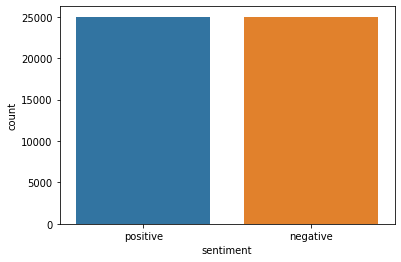

In [4]:
import seaborn as sns
sns.countplot(data.sentiment)

In [5]:
import unidecode as ud

In [6]:
def fix_accented(x):
    try:
        x = ud.unidecode(x)
    except:
        return x
    else:
        return x

In [7]:
!pip install contractions
!pip install num2words

     |████████████████████████████████| 101 kB 2.5 MB/s 


In [8]:
import contractions
from num2words import num2words

In [9]:
contractions.fix("I'm a boi")

'I am a boi'

In [10]:
def get_contractions(x):
    return contractions.fix(x)

In [11]:
num2words('2')

'two'

In [12]:
def fix_num(x):
    temp = x.split()
    sentence = []
    for i in temp:
        try:
            sentence.append(num2words(i))
        except:
            sentence.append(i)
    return ' '.join(sentence)

In [13]:
import re
import string

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
def rm_symbol(x):
    sentence = []
    for i in x:
        if i not in string.punctuation:
            sentence.append(i)
    return ''.join(sentence)

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [17]:
def rm_stopword(x):
    statement = x
    stopwrd = set(stopwords.words('english'))
    token = word_tokenize(statement)
    sentence = [i for i in token if i not in stopwrd]
    return ' '.join(sentence)

In [18]:
from nltk.stem import WordNetLemmatizer

In [19]:
def lemmatize(x):
    lemm = WordNetLemmatizer()
    return lemm.lemmatize(x)

In [20]:
def get_cleaned(x):
    x = fix_accented(x)
    x = get_contractions(x)
    x = fix_num(x)
    x = rm_symbol(x)
    x = rm_stopword(x)
    x = lemmatize(x)
    return x

In [21]:
data['review'] = data.review.apply(get_cleaned)

In [22]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
x = data.review
y = data.sentiment
trainx, testx, trainy, testy = train_test_split(x, y, random_state=344)
trainy = pd.get_dummies(trainy)
testy = pd.get_dummies(testy)

# Tokenizer

In [25]:
vocab_size = 5000
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(trainx)
def get_token(x):
    x = tokenizer.texts_to_sequences(x)
    x = pad_sequences(x, 100)
    return x
trainx = get_token(trainx.values)
testx = get_token(testx.values)

In [26]:
trainx.shape

(37500, 100)

# Model

In [27]:
model = Sequential([
    Embedding(vocab_size, 64), 
    Dropout(0.7),
#     Bidirectional(LSTM(64)), 
    LSTM(64),
    Dense(2, activation='sigmoid')
])

In [28]:
model.compile('adam', 'binary_crossentropy', ['acc'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 2)                 130       
Total params: 353,154
Trainable params: 353,154
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(trainx, trainy, batch_size=128, epochs=3, validation_split=0.2)

Train on 30000 samples, validate on 7500 samples
Epoch 1/3
30000/30000 [==============================] - 9s 295us/sample - loss: 0.4483 - acc: 0.7826 - val_loss: 0.3056 - val_acc: 0.8701
Epoch 2/3
30000/30000 [==============================] - 3s 110us/sample - loss: 0.2743 - acc: 0.8892 - val_loss: 0.3215 - val_acc: 0.8697
Epoch 3/3
30000/30000 [==============================] - 3s 110us/sample - loss: 0.2435 - acc: 0.9011 - val_loss: 0.3110 - val_acc: 0.8719


In [31]:
import matplotlib.pyplot as plt

In [32]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

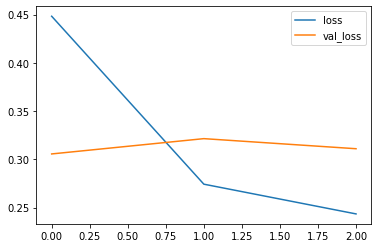

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])

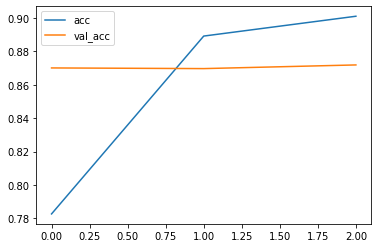

In [34]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])

In [35]:
model.evaluate(testx, testy)

12500/12500 [==============================] - 2s 120us/sample - loss: 0.3086 - acc: 0.8730


[0.308573898973465, 0.87296]

In [36]:
def get_pred(x):
    for i, j in x:
        if i>0.5:
            print('Positive')
        else:
            print('Negative')

In [37]:
def pred(x):
    x = pd.Series(x)
    for i in x:
        i = get_cleaned(i)
        i = get_token([i])
        pred = model.predict(i)
        get_pred(pred)

In [38]:
text='Basically family little boy Jake thinks zombie closet parents fighting timebr br This movie slower soap opera suddenly Jake decides become Rambo kill zombiebr br OK first going make film must Decide thriller drama As drama movie watchable Parents divorcing arguing like real life And Jake closet totally ruins film I expected see BOOGEYMAN similar movie instead watched drama meaningless thriller spotsbr br 3 ten well playing parents descent dialogs As shots Jake ignore'
pred(text)

Positive
